In [39]:
import scipy.integrate
import numpy as np

from matplotlib import pyplot
%matplotlib inline

input - **Material Properties**

In [40]:
rho_m = 0.85                     # Reflectivity of the mirror
tau_e = 0.9                      # Transmitivity of the envelope
alpha_r = 0.9                    # Absorptivity of the receiver


input - **Dimensions**

In [41]:
W_a = 0.8                    # width of the aperture in m

L = 1.25                          # length of the aperture in m
f = 0.2

D_ro = 0.0128                    # outer diameter of the receiver tube in m


sigma_sun = 0.0025
sigma_slope = 0.004
sigma_mirror = 0.002

beta = 0.18*np.pi / 180          # misalignment angle in rad
dr = 0.002                     # vertical disp of receiver in m
phi_r = np.pi / 2              # rim angle in rad

theta = 0                         # incident angle in rad


Calculation - **Intercept factor**

In [53]:
def InterceptFactorInputs( W_a, D_ro, sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r):
    "Determines the input for findInterceptFactor and call it"
    
    C = 20 #W_a / (np.pi* D_ro)
    sigma = np.sqrt(np.power(sigma_sun, 2) + 4*np.power(sigma_slope, 2) + np.power(sigma_mirror, 2))
    
#     print (sigma, C)
    sigma = 0.01
    sigmaSTAR = sigma * C
    betaSTAR = beta * C
    dSTAR = dr / D_ro
    
#     print (C)
    return InterceptFactor( sigmaSTAR, betaSTAR, dSTAR, phi_r)

In [54]:
def InterceptFactor( sigmaSTAR, betaSTAR, dSTAR, phi_r ):
    "Computes the intercept factor from the given parameters"
    
    EF = lambda phi: float(((scipy.special.erf(( np.sin(phi_r)*(1 + np.cos(phi))*(1 - 2*dSTAR*np.sin(phi)) - (np.pi*betaSTAR*(1 + np.cos(phi_r)))) / (np.sqrt(2)*np.pi*sigmaSTAR*(1 + np.cos(phi_r)))) - scipy.special.erf(-( np.sin(phi_r)*(1 + np.cos(phi))*(1 + 2*dSTAR*np.sin(phi)) + (np.pi*betaSTAR*(1 + np.cos(phi_r)))) / (np.sqrt(2)*np.pi*sigmaSTAR*(1 + np.cos(phi_r))))) / (1 + np.cos(phi))))
    
    integrated_result = scipy.integrate.quad(EF, 0, phi_r)
    IF = ((1 + np.cos(phi_r)) / (2*np.sin(phi_r))) * integrated_result[0]
    
    return IF

Calculation - **Geometric factor**

In [55]:
def GeometricFactor( W_a, f, L):
    "Determines the Geometric Factor"
    
    h_p = f
    
    GF = (2/3 * W_a * h_p + f * W_a * (1 + np.power(W_a, 2) / (48*np.power(f, 2)))) / (W_a*L)
    
    return GF

Calculation - **Optical Efficiency**

In [56]:
def OpticalEfficiency( rho_m, tau_e, alpha_r, gamma, theta, A_f):
    "Determines the Optical Efficiency"
    
    eta_o = rho_m * tau_e * alpha_r * gamma * (1 - A_f*np.tan(theta)) * np.cos(theta)
    
    return eta_o

In [57]:
gamma = InterceptFactorInputs( W_a, D_ro, sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r)

A_f = GeometricFactor( W_a, f, L)

eta_o = OpticalEfficiency( rho_m, tau_e, alpha_r, gamma, theta, A_f)

In [58]:
print (gamma, A_f, eta_o)

0.922668007572 0.32 0.635256923213


Plot - **Intercept factor** vs **Aperture width**

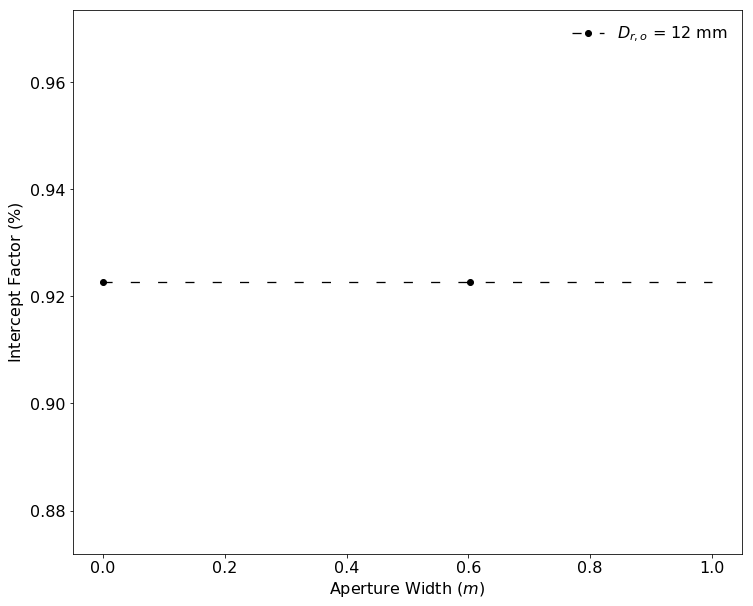

In [59]:
len = 200
Width = np.array(np.linspace(0, 1, len))
Gamma = np.zeros(len)

for i in range(len):
    Gamma[i] = InterceptFactorInputs( Width[i], D_ro, sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r)

pyplot.figure(figsize=(12,10))
pyplot.tick_params(axis='both', labelsize=16)
pyplot.xlabel('Aperture Width $(m)$', fontsize=16)
pyplot.ylabel('Intercept Factor $(\%)$', fontsize=16)

pyplot.plot(Width, Gamma, linewidth=1.3, color = 'black', linestyle=(0, (7, 14)), marker='o', markevery=120, label="$D_{r,o}$ = 12 mm")


pyplot.legend(loc=1, prop={'size': 16}, frameon=False)
# pyplot.tight_layout()

pyplot.savefig('InterceptFactor.png')

F:\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


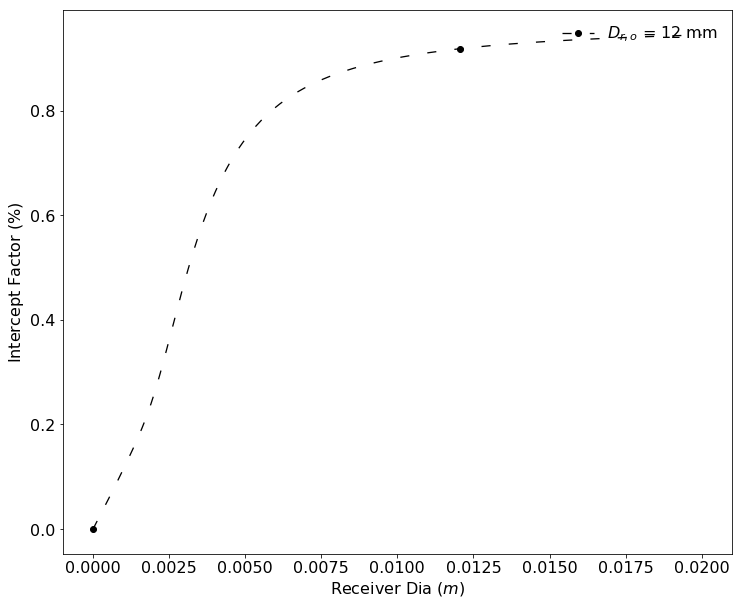

In [60]:
Dia_ro = np.array(np.linspace(0, 0.020, len))
Gamma1 = np.zeros(len)

for i in range(len):
    Gamma1[i] = InterceptFactorInputs( W_a, Dia_ro[i], sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r)

pyplot.figure(figsize=(12,10))
pyplot.tick_params(axis='both', labelsize=16)
pyplot.xlabel('Receiver Dia $(m)$', fontsize=16)
pyplot.ylabel('Intercept Factor $(\%)$', fontsize=16)

pyplot.plot(Dia_ro, Gamma1, linewidth=1.3, color = 'black', linestyle=(0, (7, 14)), marker='o', markevery=120, label="$D_{r,o}$ = 12 mm")


pyplot.legend(loc=1, prop={'size': 16}, frameon=False)
# pyplot.tight_layout()

pyplot.savefig('InterceptFactor_Dia.png')

In [62]:
InterceptFactorInputs( 0.8, 0.0254, sigma_sun, sigma_slope, sigma_mirror, 1*np.pi/180, 0.08, phi_r)

0.036771501447234262